In [1]:
!pip install -q split-folders easyocr

     |████████████████████████████████| 2.9 MB 14.0 MB/s 
     |████████████████████████████████| 619 kB 72.9 MB/s 
     |████████████████████████████████| 47.6 MB 1.7 MB/s 
     |████████████████████████████████| 145 kB 79.1 MB/s 


In [2]:
import os
import glob
#import xmltodict
import random as rnd
from PIL import Image
import splitfolders
import glob
import xml.etree.ElementTree as ET

import pandas as pd

import matplotlib
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches
from pathlib import Path

from timeit import default_timer as timer

import torch
import easyocr
from google.colab.patches import cv2_imshow


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahbaz272","key":"cf6d182d863d720869f5da8f0d4cbdd5"}'}

In [4]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d andrewmvd/car-plate-detection --force
!mkdir ./anpr
!unzip -o -qq car-plate-detection.zip -d ./anpr/

 98% 199M/203M [00:05<00:00, 43.4MB/s]
100% 203M/203M [00:05<00:00, 37.4MB/s]


In [5]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [6]:
img_names=[] 
annotations=[]
for dirname, _, filenames in os.walk("./anpr"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)
    
img_names[:10]

['Cars51.png',
 'Cars236.png',
 'Cars92.png',
 'Cars217.png',
 'Cars104.png',
 'Cars146.png',
 'Cars204.png',
 'Cars89.png',
 'Cars417.png',
 'Cars65.png']

In [7]:
annotations[:10]

['Cars258.xml',
 'Cars335.xml',
 'Cars124.xml',
 'Cars177.xml',
 'Cars99.xml',
 'Cars71.xml',
 'Cars301.xml',
 'Cars306.xml',
 'Cars97.xml',
 'Cars133.xml']

In [8]:
path_annotations="./anpr/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
        
classes = ['license']

In [9]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars258.png,400,266,158,184,230,232
1,Cars335.png,399,400,156,163,221,198
2,Cars124.png,400,267,305,256,320,267
3,Cars177.png,400,238,149,166,272,193
4,Cars99.png,375,500,70,198,262,271
...,...,...,...,...,...,...,...
466,Cars311.png,400,267,295,166,355,185
467,Cars311.png,400,267,67,91,95,98
468,Cars302.png,500,234,222,98,425,149
469,Cars401.png,400,300,158,223,238,240


Populating the interactive namespace from numpy and matplotlib


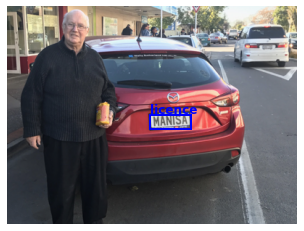

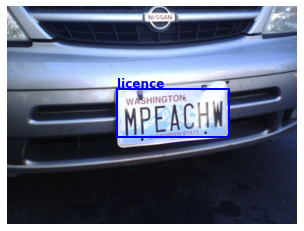

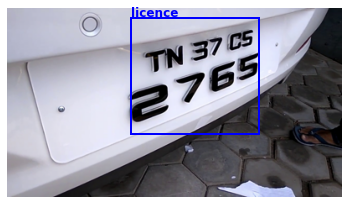

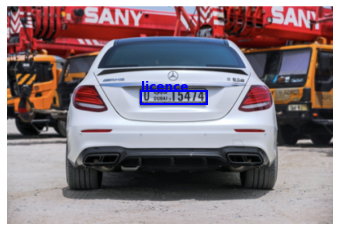

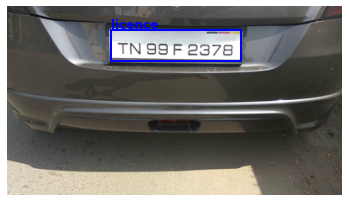

In [10]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')
                    
photos_path = "./anpr/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [11]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("./anpr/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("./anpr/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df.sort_values('file')

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
282,Cars0.png,500,268,226,125,419,173,0.645000,0.555970,0.386000,0.179104
308,Cars1.png,400,248,134,128,262,160,0.495000,0.580645,0.320000,0.129032
302,Cars10.png,400,225,140,5,303,148,0.553750,0.340000,0.407500,0.635556
147,Cars100.png,400,267,175,114,214,131,0.486250,0.458801,0.097500,0.063670
139,Cars101.png,400,300,167,202,240,220,0.508750,0.703333,0.182500,0.060000
...,...,...,...,...,...,...,...,...,...,...,...
41,Cars95.png,600,400,278,182,407,263,0.570833,0.556250,0.215000,0.202500
241,Cars96.png,400,248,133,126,261,160,0.492500,0.576613,0.320000,0.137097
9,Cars97.png,400,300,98,102,297,191,0.493750,0.488333,0.497500,0.296667
185,Cars98.png,370,400,85,196,247,259,0.448649,0.568750,0.437838,0.157500


In [12]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14474, done.
remote: Total 14474 (delta 0), reused 0 (delta 0), pack-reused 14474
Receiving objects: 100% (14474/14474), 13.62 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (9978/9978), done.


In [13]:
input_folder = Path("./anpr")
output_folder = Path("./yolov5/data/anpr_data")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1299 files [00:00, 2713.24 files/s]

Moving files finished.


In [14]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 3 directiories and 0 files in 'anpr' folder 
There are 0 directiories and 433 files in 'anpr/annotations' folder 
There are 0 directiories and 433 files in 'anpr/labels' folder 
There are 0 directiories and 433 files in 'anpr/images' folder 

There are 2 directiories and 0 files in 'yolov5/data/anpr_data' folder 
There are 3 directiories and 0 files in 'yolov5/data/anpr_data/train' folder 
There are 0 directiories and 346 files in 'yolov5/data/anpr_data/train/annotations' folder 
There are 0 directiories and 346 files in 'yolov5/data/anpr_data/train/labels' folder 
There are 0 directiories and 346 files in 'yolov5/data/anpr_data/train/images' folder 
There are 3 directiories and 0 files in 'yolov5/data/anpr_data/val' folder 
There are 0 directiories and 87 files in 'yolov5/data/anpr_data/val/annotations' folder 
There are 0 directiories and 87 files in 'yolov5/data/anpr_data/val/labels' folder 
There are 0 directiories and 87 files in 'yolov5/data/anpr_data/val/images' folder

In [15]:
import yaml

yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/anpr_data",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)


In [16]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

requirements: YOLOv5 requirement "gitpython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['gitpython']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: YOLOv5 requirements "

In [17]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp/weights/best.pt', force_reload=True)

reader = easyocr.Reader(['en'])

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-12-13 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [18]:
def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''
    
    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(plate_crop), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')#, paragraph="True", min_size=50)
    
    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to >>detections<< list'''
    
    if row[4] >= yolo_detection_prob: #discard predictions below the value             
        if(len(ocr_result))>0:
            for item in ocr_result:     
                    detections[i][0]=item[1]
                    detections[i][1]=[x1, y1]
                    detections[i][2]=item[2]
                    
    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    '''Checks if [x, y] from list coord1 is similar to coord2'''
    
    MAX_PIXELS_DIFF=50
    
    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False
    

def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''
    
    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m]=detections[n]
                        detections[n]=temp
                        
    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next >>FRAMES_TO_RESET<< frames, delete it from >>plates_data<<'''
    
    for m in range(0, len(detections)):
        if detections[m][0]=='None' and not count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]+=1
        elif count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]=0
            plates_data[m]=['None', [0,0], 0]
        else:
            count_empty_labels[m]=0
            
    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    '''Checks coordinates from >>detections<<, if there is similar record in >>plate_data<< tries to overwrite it (only if probability is higher)'''
    
    if (detections[i][2]>plates_data[i][2] or detections[i][2]==0):
        if plate_lenght:
            if len(detections[i][0])==plate_lenght:
                plates_data[i][0]=detections[i][0]
                plates_data[i][2]=detections[i][2]       
        else:
            plates_data[i][0]=detections[i][0]
            plates_data[i][2]=detections[i][2]
    plates_data[i][1]=detections[i][1]
        
    return plates_data

Photo width,height: 500,375. Detected plates: 1
Detection: 1. YOLOv5 prob: 0.74, easyOCR results: 802LIN MAY VIRGINIA 07


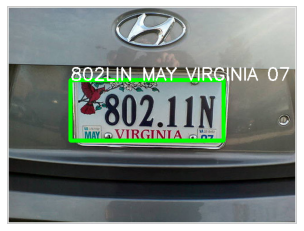

In [19]:
%matplotlib inline
import cv2
test_photo_path = "./anpr/images/Cars6.png"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Photo width,height: {width},{height}. Detected plates: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.6:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        #print(ocr_result)
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        plt.axis(False)
        plt.imshow((image)[...,::-1])
        
        print(f'Detection: {i+1}. YOLOv5 prob: {row[4]:.2f}, easyOCR results: {ocr_result[0][1]}')